In [4]:
import pandas as pd

In [16]:
df = pd.read_csv('/content/modified_ais_data.csv',nrows=100000)

In [17]:
df.head()

,BaseDateTime,MMSI,IMO,LAT,LON,SOG,COG
0,2022-03-31T00:00:01,671226100,IMO9221322,25.77626,-80.20320,3.2,143.7
1,2022-03-31T00:00:06,367452810,IMO9602344,29.32824,-94.77391,2.6,319.2
2,2022-03-31T00:00:09,366919770,IMO9253583,48.74428,-122.49504,0.0,210.3
3,2022-03-31T00:00:00,311000966,IMO8916607,18.55833,-66.47910,17.5,274.5
4,2022-03-31T00:00:01,219028420,IMO9411305,28.66703,-93.59339,9.5,129.4


In [18]:
import math

def lat_lon_to_cartesian(lat, lon, R=6371):
    lat_rad = math.radians(lat)
    lon_rad = math.radians(lon)
    x = R * math.cos(lat_rad) * math.cos(lon_rad)
    y = R * math.cos(lat_rad) * math.sin(lon_rad)
    z = R * math.sin(lat_rad)
    return x, y, z

def cartesian_to_lat_lon(x, y, z, R=6371):
    lon = math.degrees(math.atan2(y, x))
    lat = math.degrees(math.asin(z / R))
    return lat, lon


In [19]:
df[['x', 'y', 'z']] = df.apply(lambda row: pd.Series(lat_lon_to_cartesian(row['LAT'], row['LON'])), axis=1)

In [20]:
df.head()

,BaseDateTime,MMSI,IMO,LAT,LON,SOG,COG,x,y,z
0,2022-03-31T00:00:01,671226100,IMO9221322,25.77626,-80.20320,3.2,143.7,976.189651,-5653.417795,2770.480464
1,2022-03-31T00:00:06,367452810,IMO9602344,29.32824,-94.77391,2.6,319.2,-462.261129,-5535.146877,3120.593645
2,2022-03-31T00:00:09,366919770,IMO9253583,48.74428,-122.49504,0.0,210.3,-2256.980451,-3543.426543,4789.552023
3,2022-03-31T00:00:00,311000966,IMO8916607,18.55833,-66.47910,17.5,274.5,2410.348516,-5537.896973,2027.697745
4,2022-03-31T00:00:01,219028420,IMO9411305,28.66703,-93.59339,9.5,129.4,-350.359001,-5579.067584,3056.287693


In [21]:
import numpy as np
def haversine(lat1, lon1, lat2, lon2, R=6371):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

In [22]:
df["BaseDateTime"] = pd.to_datetime(df["BaseDateTime"])

In [23]:
def calculate_distances(group):
    group = group.sort_values(by="BaseDateTime")
    group["next_lat"] = group["LAT"].shift(-1)
    group["next_long"] = group["LON"].shift(-1)
    group["distance_km"] = group.apply(
        lambda row: haversine(row["LAT"], row["LON"], row["next_lat"], row["next_long"])
        if not np.isnan(row["next_lat"])
        else 0,
        axis=1,
    )
    return group.drop(columns=["next_lat", "next_long"])

In [24]:
df = df.groupby("MMSI").apply(calculate_distances).reset_index(drop=True)
df.head()

<ipython-input-24-e18fd20cbb70>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("MMSI").apply(calculate_distances).reset_index(drop=True)


,BaseDateTime,MMSI,IMO,LAT,LON,SOG,COG,x,y,z,distance_km
0,2022-03-31 00:02:32,111,IMO0000001,27.35372,-94.62546,0.4,228.6,-456.323030,-5640.208831,2927.363085,0.003950
1,2022-03-31 00:05:35,111,IMO0000001,27.35372,-94.62550,0.6,219.8,-456.326968,-5640.208513,2927.363085,0.008126
2,2022-03-31 00:08:34,111,IMO0000001,27.35377,-94.62556,0.2,221.7,-456.332668,-5640.205489,2927.368023,0.003479
3,2022-03-31 00:11:31,111,IMO0000001,27.35380,-94.62557,0.3,105.0,-456.333529,-5640.203881,2927.370986,0.022308
4,2022-03-31 00:14:33,111,IMO0000001,27.35365,-94.62542,0.3,173.4,-456.319381,-5640.212715,2927.356172,0.002224


In [25]:
def calculate_durations(group):
    # Ensure BaseDateTime is a datetime type
    group['BaseDateTime'] = pd.to_datetime(group['BaseDateTime'])
    # Calculate the duration between consecutive points in seconds
    group['duration_seconds'] = group['BaseDateTime'].diff().dt.total_seconds()
    return group

In [26]:
df = df.groupby("MMSI", group_keys=False).apply(calculate_durations)
df = df.reset_index(drop=True)
df.head()

<ipython-input-26-1fbd24d56e1c>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("MMSI", group_keys=False).apply(calculate_durations)


,BaseDateTime,MMSI,IMO,LAT,LON,SOG,COG,x,y,z,distance_km,duration_seconds
0,2022-03-31 00:02:32,111,IMO0000001,27.35372,-94.62546,0.4,228.6,-456.323030,-5640.208831,2927.363085,0.003950,NaN
1,2022-03-31 00:05:35,111,IMO0000001,27.35372,-94.62550,0.6,219.8,-456.326968,-5640.208513,2927.363085,0.008126,183.0
2,2022-03-31 00:08:34,111,IMO0000001,27.35377,-94.62556,0.2,221.7,-456.332668,-5640.205489,2927.368023,0.003479,179.0
3,2022-03-31 00:11:31,111,IMO0000001,27.35380,-94.62557,0.3,105.0,-456.333529,-5640.203881,2927.370986,0.022308,177.0
4,2022-03-31 00:14:33,111,IMO0000001,27.35365,-94.62542,0.3,173.4,-456.319381,-5640.212715,2927.356172,0.002224,182.0


In [ ]:
df_new = df[['x','y','z','distance_km','duration_seconds','SOG','COG']]

In [ ]:
df_new.head()

,x,y,z,distance_km,duration_seconds,SOG,COG
0,978.775466,-5636.091653,2804.658708,0.000000,NaN,0.1,220.5
1,-2409.574733,-3746.291746,4555.094813,0.000000,NaN,0.0,218.5
2,985.603053,-5636.104757,2802.240317,0.563219,NaN,28.3,272.6
3,985.048333,-5636.202230,2802.239319,0.000000,62.0,14.9,269.4
4,977.761677,-5441.347041,3166.285755,0.000000,NaN,10.6,186.0


Velocity Components:

Convert speed over ground (SOG) to meters per second:
Speed
(
m/s
)
=
SOG (knots)
×
0.514444
Speed(m/s)=SOG (knots)×0.514444
Calculate the velocity components using COG (Course Over Ground in degrees):
𝑣
𝑥
=
Speed
×
cos
⁡
(
COG in radians
)
v
x
​
 =Speed×cos(COG in radians)
𝑣
𝑦
=
Speed
×
sin
⁡
(
COG in radians
)
v
y
​
 =Speed×sin(COG in radians)

The 2D position update formula calculates the new position
(
𝑥
next
,
𝑦
next
)
(x
next
​
 ,y
next
​
 ) of an object moving in a 2D plane, given its current position
(
𝑥
,
𝑦
)
(x,y), speed, direction, and time interval.

Formula:
𝑥
next
=
𝑥
+
𝑣
𝑥
⋅
Δ
𝑡
x
next
​
 =x+v
x
​
 ⋅Δt
𝑦
next
=
𝑦
+
𝑣
𝑦
⋅
Δ
𝑡
y
next
​
 =y+v
y
​
 ⋅Δt
Where:

𝑣
𝑥
v
x
​
  and
𝑣
𝑦
v
y
​
  are the velocity components in the
𝑥
x- and
𝑦
y-directions, respectively:

𝑣
𝑥
=
𝑣
⋅
cos
⁡
(
𝜃
)
v
x
​
 =v⋅cos(θ)
𝑣
𝑦
=
𝑣
⋅
sin
⁡
(
𝜃
)
v
y
​
 =v⋅sin(θ)
𝑣
v is the speed (in meters per second or any consistent unit).

𝜃
θ is the direction of movement in radians (e.g., the Course Over Ground (COG) in nautical contexts).

Δ
𝑡
Δt is the duration of movement (in seconds or any consistent unit).

Example:
If an object is moving with:

Current position
(
𝑥
,
𝑦
)
=
(
100
,
200
)
(x,y)=(100,200),
Speed
𝑣
=
5
v=5 m/s,
Direction
𝜃
=
4
5
∘
θ=45
∘
  (or
𝜋
/
4
π/4 radians),
Duration
Δ
𝑡
=
10
Δt=10 seconds,
We calculate:

𝑣
𝑥
=
5
⋅
cos
⁡
(
𝜋
/
4
)
=
5
⋅
0.707
≈
3.535
v
x
​
 =5⋅cos(π/4)=5⋅0.707≈3.535
𝑣
𝑦
=
5
⋅
sin
⁡
(
𝜋
/
4
)
=
5
⋅
0.707
≈
3.535
v
y
​
 =5⋅sin(π/4)=5⋅0.707≈3.535
Update positions:
𝑥
next
=
100
+
3.535
⋅
10
=
135.35
x
next
​
 =100+3.535⋅10=135.35
𝑦
next
=
200
+
3.535
⋅
10
=
235.35
y
next
​
 =200+3.535⋅10=235.35
The new position is approximately:

(
𝑥
next
,
𝑦
next
)
=
(
135.35
,
235.35
)
(x
next
​
 ,y
next
​
 )=(135.35,235.35)

In [ ]:
def calculate_next_positions(df):
    # Define constants
    KNOTS_TO_METERS_PER_SEC = 0.514444

    # Initialize new columns
    df["lx"] = df["x"]  # Default to current x
    df["ly"] = df["y"]  # Default to current y
    df["lz"] = df["z"]  # Default to current z

    for i in range(len(df) - 1):  # Loop through all except the last row
        # Skip rows with NaN duration or speed
        if pd.isna(df.loc[i, "duration_seconds"]) or df.loc[i, "SOG"] == 0:
            continue

        # Convert SOG to meters per second
        speed = df.loc[i, "SOG"] * KNOTS_TO_METERS_PER_SEC

        # Convert COG to radians
        cog_radians = np.radians(df.loc[i, "COG"])

        # Compute velocity components
        vx = speed * np.cos(cog_radians)
        vy = speed * np.sin(cog_radians)

        # Calculate next positions
        df.loc[i + 1, "lx"] = df.loc[i, "x"] + vx * df.loc[i, "duration_seconds"]
        df.loc[i + 1, "ly"] = df.loc[i, "y"] + vy * df.loc[i, "duration_seconds"]
        df.loc[i + 1, "lz"] = df.loc[i, "z"]  # Assume z remains constant

    return df



In [ ]:
pred_df = calculate_next_positions(df)
pred_df.head()

,BaseDateTime,MMSI,IMO,LAT,LON,SOG,COG,x,y,z,distance_km,duration_seconds,lx,ly,lz
0,2022-03-31 00:00:17,1056261,IMO1056261,26.11809,-80.14815,0.1,220.5,978.775466,-5636.091653,2804.658708,0.000000,NaN,978.775466,-5636.091653,2804.658708
1,2022-03-31 00:01:13,209136000,IMO9416707,45.64101,-122.74869,0.0,218.5,-2409.574733,-3746.291746,4555.094813,0.000000,NaN,-2409.574733,-3746.291746,4555.094813
2,2022-03-31 00:00:01,209513000,IMO9060247,26.09387,-80.08081,28.3,272.6,985.603053,-5636.104757,2802.240317,0.563219,NaN,985.603053,-5636.104757,2802.240317
3,2022-03-31 00:01:03,209513000,IMO9060247,26.09386,-80.08645,14.9,269.4,985.048333,-5636.202230,2802.239319,0.000000,62.0,985.048333,-5636.202230,2802.239319
4,2022-03-31 00:00:00,209613000,IMO9266542,29.80067,-79.81317,10.6,186.0,977.761677,-5441.347041,3166.285755,0.000000,NaN,980.071687,-6111.419540,2802.239319


In [ ]:
import numpy as np
import pandas as pd

def predict_positions_between_lost_and_found(lost_row, found_row):
    """
    Predict intermediate positions between a lost row and a found row,
    including computation of `distance_km` for each predicted step.

    Parameters:
    lost_row (pd.Series): Row with initial "lost" position and SOG/COG.
    found_row (pd.Series): Row with final "found" position and SOG/COG.

    Returns:
    pd.DataFrame: Predicted positions up to the found row.
    """
    KNOTS_TO_METERS_PER_SEC = 0.514444

    # Extract initial and final positions
    x_start, y_start, z_start = lost_row["x"], lost_row["y"], lost_row["z"]
    x_end, y_end, z_end = found_row["x"], found_row["y"], found_row["z"]

    # Extract initial and final speeds and angles
    sog_start, cog_start = lost_row["SOG"], lost_row["COG"]
    sog_end, cog_end = found_row["SOG"], found_row["COG"]

    # Calculate total duration
    duration_total = found_row["duration_seconds"]

    # Number of prediction steps
    num_steps = int(duration_total)  # Assume one step per second
    if num_steps <= 0:
        raise ValueError("Duration between lost and found rows must be positive.")

    # Initialize the prediction DataFrame
    predictions = []
    cumulative_distance = 0  # Initialize cumulative distance

    # Start position for cumulative distance calculation
    x_previous, y_previous, z_previous = x_start, y_start, z_start

    for step in range(1, num_steps + 1):
        # Interpolate speed (SOG) and course (COG)
        sog_interp = sog_start + (sog_end - sog_start) * step / num_steps
        cog_interp = cog_start + (cog_end - cog_start) * step / num_steps

        # Convert SOG to meters per second
        speed = sog_interp * KNOTS_TO_METERS_PER_SEC

        # Convert COG to radians
        cog_radians = np.radians(cog_interp)

        # Compute velocity components
        vx = speed * np.cos(cog_radians)
        vy = speed * np.sin(cog_radians)

        # Compute position increment
        time_step = duration_total / num_steps
        dx = vx * time_step
        dy = vy * time_step

        # Calculate intermediate positions
        x_current = x_start + dx * step
        y_current = y_start + dy * step
        z_current = z_start + (z_end - z_start) * step / num_steps

        # Compute step distance and update cumulative distance
        step_distance = np.sqrt((x_current - x_previous)**2 + (y_current - y_previous)**2 + (z_current - z_previous)**2)
        cumulative_distance += step_distance
        distance_km = cumulative_distance / 1000  # Convert to kilometers

        # Update previous position
        x_previous, y_previous, z_previous = x_current, y_current, z_current

        # Append the prediction
        predictions.append({
            "step": step,
            "SOG": sog_interp,
            "COG": cog_interp,
            "x": x_current,
            "y": y_current,
            "z": z_current,
            "time_elapsed": step * time_step,
            "distance_km": distance_km
        })

    # Convert predictions to a DataFrame
    predictions_df = pd.DataFrame(predictions)
    return predictions_df

# Example usage:
lost_row = pd.Series({
    "SOG": 0.1,
    "COG": 220.5,
    "x": 978.775466,
    "y": -5636.091653,
    "z": 2804.658708,
    "distance_km": 0.563219,
    "duration_seconds": 62.0
})

found_row = pd.Series({
    "SOG": 10.6,
    "COG": 186.0,
    "x": 977.761677,
    "y": -5441.347041,
    "z": 3166.285755,
    "distance_km": 0.563219,
    "duration_seconds": 62.0
})

# Predict positions between lost and found
predicted_positions = predict_positions_between_lost_and_found(lost_row, found_row)

# Display the predicted positions
print(predicted_positions)


    step        SOG         COG           x            y            z  \
0      1   0.269355  219.943548  978.669229 -5636.180618  2810.491402   
1      2   0.438710  219.387097  978.426603 -5636.378081  2816.324097   
2      3   0.608065  218.830645  978.044414 -5636.680078  2822.156791   
3      4   0.777419  218.274194  977.519570 -5637.082582  2827.989485   
4      5   0.946774  217.717742  976.849051 -5637.581508  2833.822180   
..   ...        ...         ...         ...          ...          ...   
57    58   9.922581  188.225806  685.753941 -5678.451428  3142.954978   
58    59  10.091935  187.669355  675.203112 -5676.970921  3148.787672   
59    60  10.261290  187.112903  664.481453 -5675.310922  3154.620366   
60    61  10.430645  186.556452  653.591272 -5673.466301  3160.453061   
61    62  10.600000  186.000000  642.534976 -5671.431953  3166.285755   

    time_elapsed  distance_km  
0            1.0     0.005834  
1            2.0     0.011675  
2            3.0     0.0175

In [37]:
single_imo = df.head(20)
single_imo = single_imo[['x','y','z','distance_km','duration_seconds','SOG','COG']]
single_imo

,x,y,z,distance_km,duration_seconds,SOG,COG
0,-456.323030,-5640.208831,2927.363085,0.003950,NaN,0.4,228.6
1,-456.326968,-5640.208513,2927.363085,0.008126,183.0,0.6,219.8
2,-456.332668,-5640.205489,2927.368023,0.003479,179.0,0.2,221.7
3,-456.333529,-5640.203881,2927.370986,0.022308,177.0,0.3,105.0
4,-456.319381,-5640.212715,2927.356172,0.002224,182.0,0.3,173.4
5,-456.319299,-5640.211696,2927.358147,0.013191,180.0,0.4,240.9
6,-456.313923,-5640.206492,2927.369011,0.014004,179.0,0.2,219.0
7,-456.327787,-5640.206396,2927.367036,0.014060,180.0,0.4,203.0
8,-456.318314,-5640.211776,2927.358147,0.003165,181.0,0.6,211.7
9,-456.321226,-5640.211028,2927.359135,0.007979,183.0,0.4,215.9


In [61]:
single_imo[['lat','lon']] = single_imo.apply(lambda row: pd.Series(cartesian_to_lat_lon(row['x'], row['y'],row['z'])), axis=1)
single_imo


,x,y,z,distance_km,duration_seconds,SOG,COG,lat,lon
0,-456.323030,-5640.208831,2927.363085,0.003950,NaN,0.4,228.6,27.35372,-94.62546
1,-456.326968,-5640.208513,2927.363085,0.008126,183.0,0.6,219.8,27.35372,-94.62550
2,-456.332668,-5640.205489,2927.368023,0.003479,179.0,0.2,221.7,27.35377,-94.62556
3,-456.333529,-5640.203881,2927.370986,0.022308,177.0,0.3,105.0,27.35380,-94.62557
4,-456.319381,-5640.212715,2927.356172,0.002224,182.0,0.3,173.4,27.35365,-94.62542
5,-456.319299,-5640.211696,2927.358147,0.013191,180.0,0.4,240.9,27.35367,-94.62542
6,-456.313923,-5640.206492,2927.369011,0.014004,179.0,0.2,219.0,27.35378,-94.62537
7,-456.327787,-5640.206396,2927.367036,0.014060,180.0,0.4,203.0,27.35376,-94.62551
8,-456.318314,-5640.211776,2927.358147,0.003165,181.0,0.6,211.7,27.35367,-94.62541
9,-456.321226,-5640.211028,2927.359135,0.007979,183.0,0.4,215.9,27.35368,-94.62544


In [84]:
import numpy as np
import pandas as pd

def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the Haversine distance between two points on the Earth's surface.
    Parameters:
    lat1, lon1: Latitude and Longitude of the first point (in degrees)
    lat2, lon2: Latitude and Longitude of the second point (in degrees)
    Returns:
    Distance in kilometers
    """
    R = 6371  # Radius of the Earth in kilometers
    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    # Distance in kilometers
    distance = R * c
    return distance

def predict_positions_between_lost_and_found(lost_row, found_row):
    """
    Predict intermediate positions between a lost row and a found row using interpolation for SOG and COG.
    Parameters:
    lost_row (pd.Series): Row with initial "lost" position and SOG/COG.
    found_row (pd.Series): Row with final "found" position and SOG/COG.
    Returns:
    pd.DataFrame: Predicted positions up to the found row.
    """
    KNOTS_TO_METERS_PER_SEC = 0.514444

    # Extract initial and final positions
    lat_start, lon_start, z_start = lost_row["x"], lost_row["y"], lost_row["z"]
    lat_end, lon_end, z_end = found_row["x"], found_row["y"], found_row["z"]

    # Extract initial and final SOG and COG
    sog_start, cog_start = lost_row["SOG"], lost_row["COG"]
    sog_end, cog_end = found_row["SOG"], found_row["COG"]

    # Calculate initial distance between lost and found
    initial_distance_km = haversine_distance(lat_start, lon_start, lat_end, lon_end)

    # Calculate total duration
    duration_total = found_row["duration_seconds"]

    # Time step
    num_steps = 10  # One step per second
    if num_steps <= 0:
        raise ValueError("Duration between lost and found rows must be positive.")
    time_step = duration_total / num_steps

    # Initialize the prediction DataFrame
    predictions = []

    # Iterate through each time step
    for step in range(1, num_steps + 1):
        # Calculate the remaining distance at this step
        remaining_distance_km = initial_distance_km * (1 - step / num_steps)

        # Interpolate SOG and COG for the current step
        sog_interp = sog_start + (sog_end - sog_start) * step / num_steps
        cog_interp = cog_start + (cog_end - cog_start) * step / num_steps

        # Gradually decelerate the speed based on remaining distance
        sog_interp = sog_interp * (remaining_distance_km / initial_distance_km)

        # Convert SOG to meters per second
        speed = sog_interp * KNOTS_TO_METERS_PER_SEC

        # Convert COG to radians
        cog_radians = np.radians(cog_interp)

        # Compute velocity components
        vx = speed * np.cos(cog_radians)
        vy = speed * np.sin(cog_radians)

        # Compute position increment
        dx = vx * time_step
        dy = vy * time_step

        # Calculate intermediate positions
        x_current = lat_start + dx * step
        y_current = lon_start + dy * step
        z_current = z_start + (z_end - z_start) * step / num_steps

        # Calculate the distance from the start using the Haversine formula
        distance_km = haversine_distance(lat_start, lon_start, x_current, y_current)

        # Append the prediction
        predictions.append({
            "step": step,
            "SOG": sog_interp,
            "COG": cog_interp,
            "x": x_current,
            "y": y_current,
            "z": z_current,
            "time_elapsed": step * time_step,
            "distance_km": distance_km
        })

    # Ensure the last step matches the found position
    predictions[-1]["x"] = lat_end
    predictions[-1]["y"] = lon_end
    predictions[-1]["z"] = z_end
    predictions[-1]["distance_km"] = haversine_distance(lat_start, lon_start, lat_end, lon_end)

    # Convert predictions to a DataFrame
    predictions_df = pd.DataFrame(predictions)

    return predictions_df


lost_row = df.iloc[5]
found_row = df.iloc[10]

# Predict positions between lost and found
predicted_positions = predict_positions_between_lost_and_found(lost_row, found_row)

# Display the predicted positions
print(predicted_positions)


   step    SOG     COG           x            y            z  time_elapsed  \
0     1  0.351  238.54 -457.987346 -5642.937973  2927.358345          17.7   
1     2  0.304  236.18 -459.400691 -5644.811151  2927.358542          35.4   
2     3  0.259  233.82 -460.495898 -5645.922477  2927.358740          53.1   
3     4  0.216  231.46 -461.221099 -5646.365280  2927.358937          70.8   
4     5  0.175  229.10 -461.535914 -5646.233922  2927.359135          88.5   
5     6  0.136  226.74 -461.411302 -5645.622762  2927.359332         106.2   
6     7  0.099  224.38 -460.829320 -5644.625153  2927.359530         123.9   
7     8  0.064  222.02 -459.782823 -5643.332457  2927.359727         141.6   
8     9  0.031  219.66 -458.275074 -5641.833107  2927.359925         159.3   
9    10  0.000  217.30 -456.329060 -5640.209881  2927.360122         177.0   

   distance_km  
0   189.229328  
1   349.429832  
2   473.041887  
3   554.180743  
4   588.511917  
5   573.128709  
6   506.435692  
7   3

In [85]:
predicted_positions[['pred_lat','pred_lon']] = predicted_positions.apply(lambda row: pd.Series(cartesian_to_lat_lon(row['x'], row['y'],row['z'])), axis=1)
predicted_positions


,step,SOG,COG,x,y,z,time_elapsed,distance_km,pred_lat,pred_lon
0,1,0.351,238.54,-457.987346,-5642.937973,2927.358345,17.7,189.229328,27.353672,-94.640021
1,2,0.304,236.18,-459.400691,-5644.811151,2927.358542,35.4,349.429832,27.353674,-94.652740
2,3,0.259,233.82,-460.495898,-5645.922477,2927.358740,53.1,473.041887,27.353676,-94.662869
3,4,0.216,231.46,-461.221099,-5646.365280,2927.358937,70.8,554.180743,27.353678,-94.669815
4,5,0.175,229.10,-461.535914,-5646.233922,2927.359135,88.5,588.511917,27.353680,-94.673097
5,6,0.136,226.74,-461.411302,-5645.622762,2927.359332,106.2,573.128709,27.353682,-94.672344
6,7,0.099,224.38,-460.829320,-5644.625153,2927.359530,123.9,506.435692,27.353684,-94.667298
7,8,0.064,222.02,-459.782823,-5643.332457,2927.359727,141.6,388.040217,27.353686,-94.657808
8,9,0.031,219.66,-458.275074,-5641.833107,2927.359925,159.3,218.653211,27.353688,-94.643829
9,10,0.000,217.30,-456.329060,-5640.209881,2927.360122,177.0,1.085670,27.353690,-94.625520


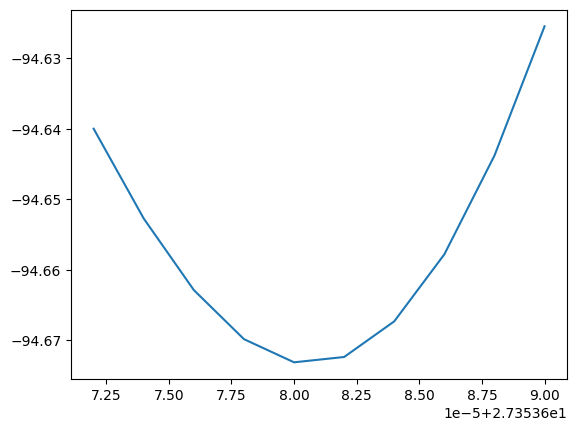

In [86]:
import matplotlib.pyplot as plt
plt.plot(predicted_positions['pred_lat'],predicted_positions['pred_lon'])
plt.show()

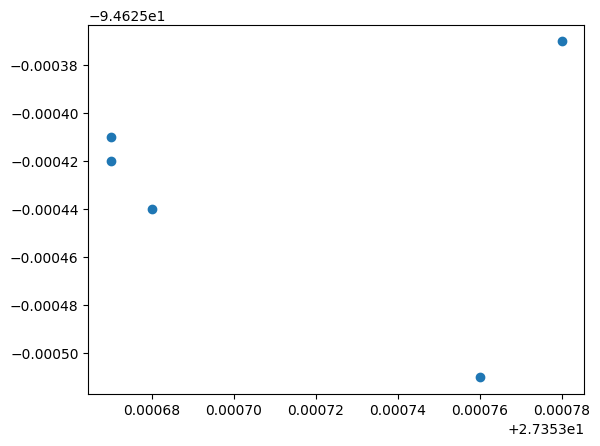

In [93]:
plt.scatter(single_imo['lat'][5:10],single_imo['lon'][5:10])
plt.show()